# Quantum state preparation and unitary syntheis using Proximal Policy Optimization (PPO)

The PPO agent is implemented in the Stable Baselines 3 library

In [1]:
from environment.Qenv_unitary import Qenv_unitary_gym
from environment.Qenv_state import Qenv_state_gym
from environment.Qenv_state_ising import Qenv_ising_state_gym
from environment.Qsim import Ising_Hamiltonian
from utils import *
import os
import torch as pt
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import StopTrainingOnMaxEpisodes
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO

device = pt.device('cuda:0' if pt.cuda.is_available() else 'cpu')

Define parameters

Here you can see how to define the parameters for the three environments as well as for the agent

In [2]:
# Parameters for unitary environment
env_params_unitary = dict(
    N=1,
    goals=None,
    num_goals=1,
    max_steps=100, 
    fidelity_threshold=0.99,
    fidelity_function='Haar_integral',
    sparse_reward=False,
    qgates='HRC',
    adjoint=False,
    qubit_connectivity=None,
    device=device
)

In [3]:
# Parameters for state environment
env_params_state = dict(
    N=1,
    goals=None,
    num_goals=1,
    max_steps=100, 
    fidelity_threshold=0.99,
    sparse_reward=False,
    qgates='HRC',
    adjoint=False,
    inverse_circuit=False,
    obs_type='Single',
    qubit_connectivity=None,
    device=device)

In [4]:
# Parameters for Ising environment
experiment = 'A'    # Options: A, B

if experiment == 'A':
    starts_ = 'ground states'
    ground_state_params_ = dict(J = -1, gx = [1, 1.1], gz = 0)
    delta_t_ = 6.
    fidelity_threshold_ = 0.96
    env_name_ = 'case_A'
    target_state_params_ = dict(J = -1, gx = 0, gz = 0)

elif experiment == 'B':
    starts_ = 'ground states'
    ground_state_params_ = dict(J = -1, gx = [1, 1.1], gz = [0, 0.5])
    delta_t_ = 6.
    fidelity_threshold_ = 0.93
    env_name_ = 'case_B'
    target_state_params_ = dict(J = +1, gx = 0.5, gz = 1.5)

env_params_ising = dict(
    N = 4,
    starts = starts_,
    num_starts = -1,
    ground_states_params = ground_state_params_,
    delta_t = delta_t_,
    reward_function = 'log fidelity',
    max_steps = 50,
    fidelity_threshold = fidelity_threshold_,
    device=device)

# Get Ising goal
H, eigenvalues, eigenvectors = Ising_Hamiltonian(N=env_params_ising['N'], **target_state_params_)
goal = eigenvectors[0]
env_params_ising['goal'] = goal

In [5]:
env_type = 'unitary'        # Options are 'unitary', 'state' and 'ising'

if env_type == 'unitary':
    env_params = env_params_unitary
elif env_type == 'state':
    env_params = env_params_state
elif env_type == 'ising':
    env_params = env_params_ising

# Training 
num_episodes = int(1e4)
train_steps = num_episodes * env_params['max_steps']
log_dir = "logs/"
os.makedirs(log_dir, exist_ok=True)

agent_params = dict(
    policy = "MlpPolicy",
    policy_kwargs=dict(net_arch=[200, 200],
                    activation_fn = pt.nn.Tanh),
    learning_rate=1e-4,
    #ent_coef=0.01,
    gamma=0.98,
    batch_size=128,
    verbose=1, 
    device=device)

Create environment

logs_env is a wrapper enviornment to save the results of each episode during training, they are saved in log_dir/monitor.csv

In [6]:
if env_type == 'unitary':
    env = Qenv_unitary_gym(**env_params)
elif env_type == 'state':
    env = Qenv_state_gym(**env_params)
elif env_type == 'ising':
    env = Qenv_ising_state_gym(**env_params)

logs_env = Monitor(env, filename=log_dir, info_keywords=("is_success", "Fidelity", "Goal", "Circuit"))

agent_params['env'] = logs_env

Create agent

In [7]:
model = PPO(**agent_params)

Using cuda:0 device
Wrapping the env in a DummyVecEnv.


Train agent

In [8]:
log_interval = 5
max_episodes_callback = StopTrainingOnMaxEpisodes(max_episodes=num_episodes, verbose=1)
model.learn(total_timesteps=train_steps, log_interval=log_interval, callback=max_episodes_callback);

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 95.1         |
|    ep_rew_mean          | -70.4        |
|    success_rate         | 0.09         |
| time/                   |              |
|    fps                  | 62           |
|    iterations           | 5            |
|    time_elapsed         | 162          |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0075485497 |
|    clip_fraction        | 0.0114       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explained_variance   | 0.00185      |
|    learning_rate        | 0.0001       |
|    loss                 | 3.33         |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00283     |
|    value_loss           | 16.2         |
------------------------------------------
------------------------------------------
| rollout/ 

Show results

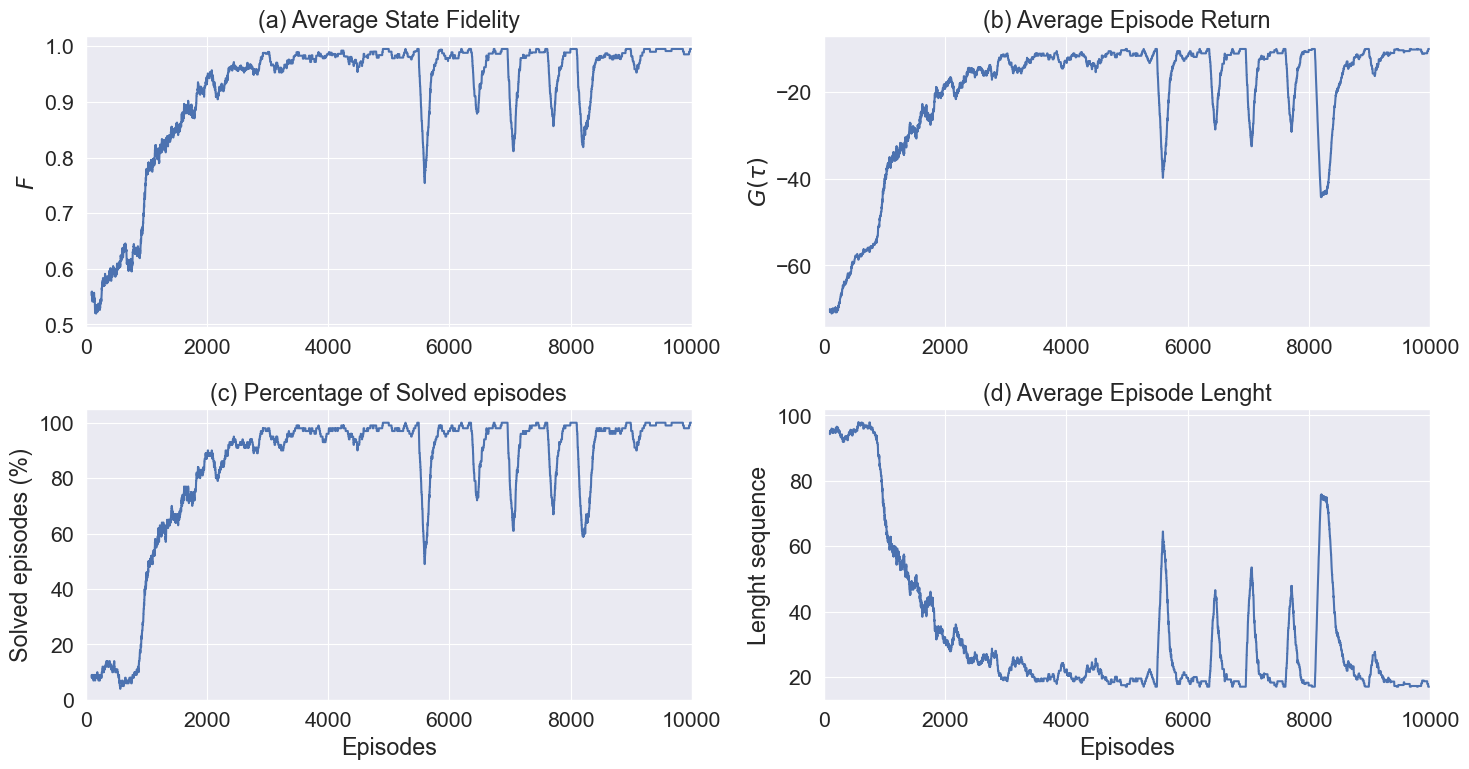

In [9]:
file = log_dir + "monitor.csv"
plot_results(file, window=int(100))

Test agent

In [10]:
rewards, lenghts = evaluate_policy(model, env,n_eval_episodes=10,deterministic=True,return_episode_rewards=True)

c:\Users\rober\anaconda3\envs\qcompRL\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Save results

In [ ]:
model.save(log_dir + f'{env_params["N"]}Q_{env_type}_PPO')